In [304]:
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

In [305]:
df = pd.read_csv('magneto.csv', encoding = 'utf-8')

In [306]:
t_format = '%Y-%m-%dT%H:%M:%SZ'
t_tag = np.asarray([datetime.strptime(i, t_format)for i in df['time_tag']])
He = np.asarray([i for i in df['He']])
Hp = np.asarray([i for i in df['Hp']])
Hn = np.asarray([i for i in df['Hn']])


In [307]:
def fourier(v, nhar):#FFT with output coeff a_k, b_k
    npts    = len(v)
    f       = 2.0/npts
    t       = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    vmn     = np.mean(v)
    v       = v - vmn
    cofs    = [0]*(nhar+1)
    cofs[0] = (vmn,0)
    for i in range(1,nhar+1):
        c, s    = np.cos(i*t), np.sin(i*t)
        cofs[i] = (np.dot(v,c)*f, np.dot(v,s)*f)
    return (cofs)

def fourier_synth(cofs, npts):
    nt  = len(cofs)
    syn = np.zeros(npts)
    t  = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    for n in range(1, nt):
        for j in range(npts):
            syn[j] += cofs[n][0]*np.cos(n*t[j]) + cofs[n][1]*np.sin(n*t[j])
    return (syn)


In [308]:
int_pr = pd.read_csv('int_pr.csv', encoding = 'utf-8')
int_el = pd.read_csv('int_el.csv', encoding = 'utf-8')
int_pr = int_pr[int_pr.energy == '>=10 MeV']
int_el = int_el[int_el.energy == '>=2 MeV']

int_flux_el = np.asarray(int_el.flux)
time_tag_el = np.asarray([datetime.strptime(i, t_format)for i in int_el['time_tag']])

int_flux_pr = np.asarray(int_pr.flux)
time_tag_pr = np.asarray([datetime.strptime(i, t_format)for i in int_pr['time_tag']])


100%|██████████| 61/61 [00:01<00:00, 53.92it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


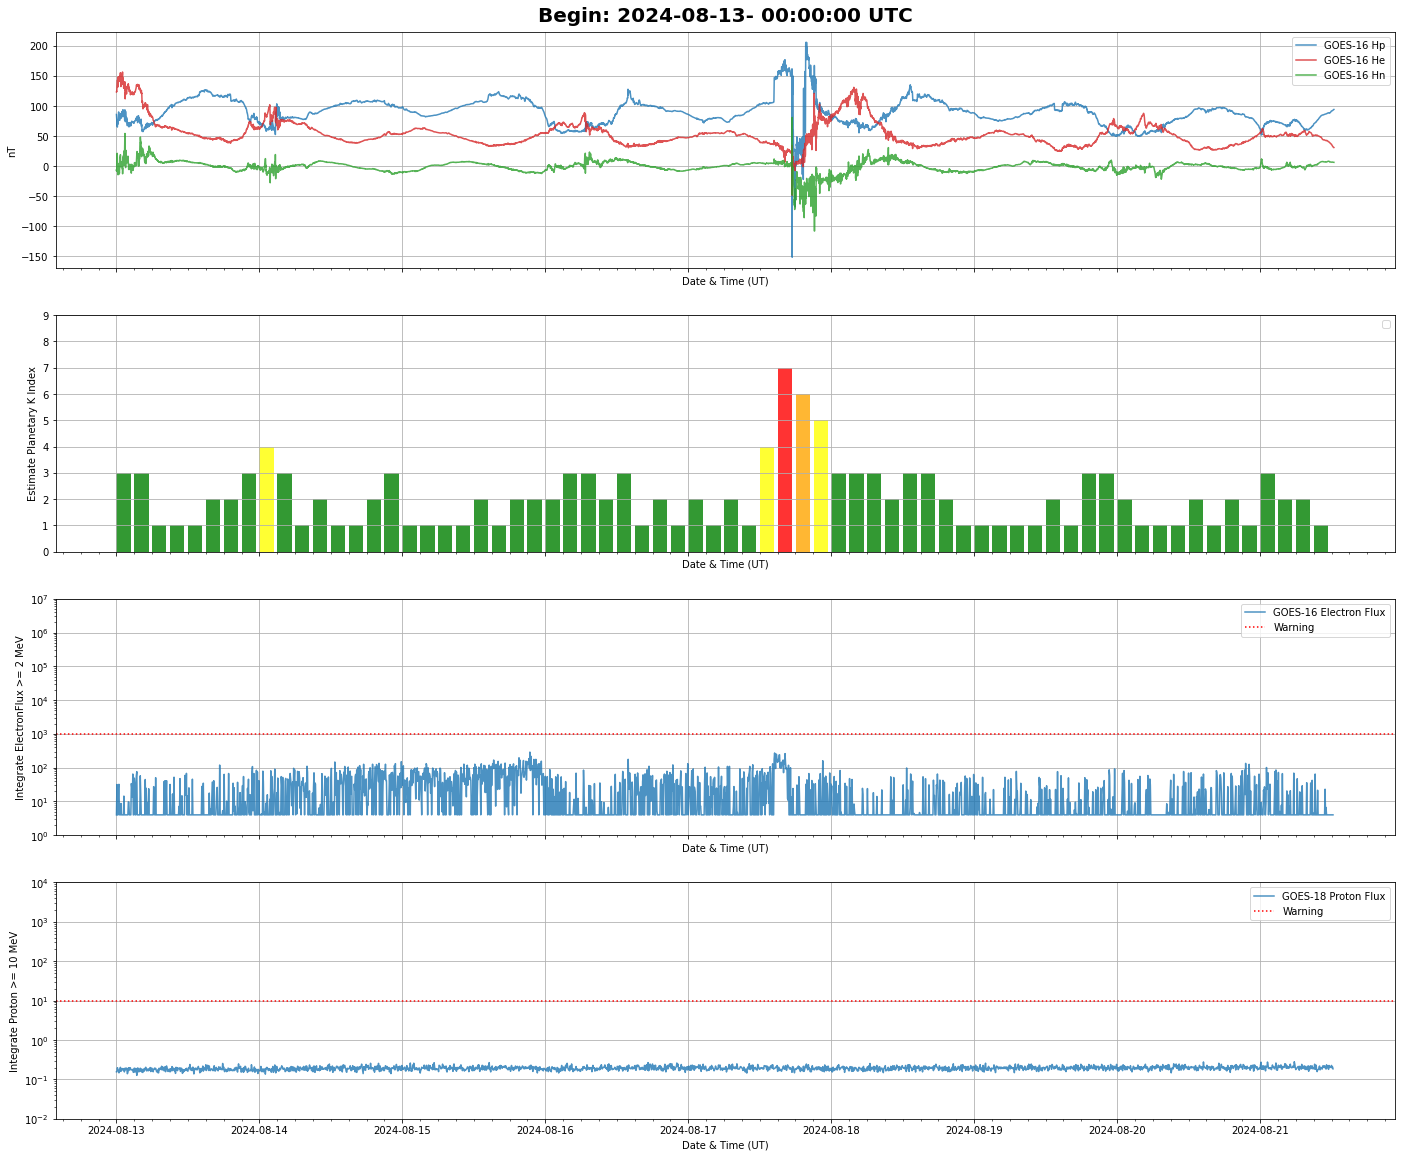

In [309]:
#Using Hp data!
    
tag = t_tag
    
He = np.asarray([i for i in df['He']])
Hp = np.asarray([i for i in df['Hp']])
Hn = np.asarray([i for i in df['Hn']])

H = Hp
#H = np.asarray([i for i in df['total']])
intervals = (len(H)-1260)//180
    
tmp = np.asarray([H[i*180:1440+i*180] for i in range(intervals)]), np.asarray([tag[j*180:1440+j*180] for j in range(intervals)])
tmp_mean = np.mean(tmp[0], axis = 1)
        
t = np.array([])
x = np.array([])
synx = np.array([])

for i in tqdm(range(intervals)):
        
    tpx = tmp[0][i] - tmp_mean[i] # He-He.mean()
    x_cofs = fourier(tpx, 3)
    tpsyn = fourier_synth(x_cofs, 1440)
        
    if i == 0:
        
        x = np.append(x, tpx)
        synx = np.append(synx, tpsyn)
        t = np.append(t, tmp[1][i])
        
    else:
        x = np.append(x, tpx[-180:])
        synx = np.append(synx, tpsyn[-180:])
        t = np.append(t, tmp[1][i][-180:])
            
    #plt.figure(figsize = [50, 16])        
    #plt.plot(t, x)
    #plt.plot(t, synx)
    
maxX = np.max((x-synx).reshape(intervals + 7, 180), axis = 1)
minX = np.min((x-synx).reshape(intervals + 7, 180), axis = 1)
    
t_3hours = t[::180]
    
k_scale = np.asarray([0, 8, 15, 30, 60, 105, 180, 300, 500, 750])/3*4
    
k_nT = maxX-minX
k_index= np.digitize(k_nT, bins = k_scale)
    
    
fig, axes = plt.subplots(4,1, figsize = [24, 20], sharex = True)

axes[0].set_title('Begin: 2024-08-13- 00:00:00 UTC', fontsize=20, fontweight='bold', va = 'bottom', ha = 'center')

axes[0].plot(tag, Hp, color = 'tab:blue', alpha = 0.8, label = 'GOES-16 Hp')
axes[0].plot(tag, He, color = 'tab:red', alpha = 0.8, label = 'GOES-16 He')
axes[0].plot(tag, Hn, color = 'tab:green', alpha = 0.8, label = 'GOES-16 Hn')

axes[0].set_ylabel('nT')

profit_color = [{p<4: 'green', 4<=p<6: 'yellow', 6<=p<7: 'orange', p>=7:'red'}[True] for p in k_index]

axes[1].bar(t_3hours, k_index, width = 0.1, color = profit_color, align = 'edge', alpha = 0.8)
axes[1].set_ylabel('Estimate Planetary K Index')
axes[1].set_ybound(lower = 0, upper = 9)

    
axes[2].plot(time_tag_el, int_flux_el, label = 'GOES-16 Electron Flux', alpha = 0.8)
axes[2].set_yscale('log')
axes[2].set_ybound(lower = 1e0, upper = 1e7)
axes[2].axhline(1e3, color = 'red', linestyle = ':', label = 'Warning')
axes[2].set_ylabel('Integrate ElectronFlux >= 2 MeV')




axes[3].plot(time_tag_pr, int_flux_pr, label = 'GOES-18 Proton Flux', alpha = 0.8)
axes[3].set_yscale('log')
axes[3].set_ybound(lower = 1e-2, upper = 1e4)
axes[3].axhline(1e1, color = 'red', linestyle = ':', label = 'Warning')
axes[3].set_ylabel('Integrate Proton >= 10 MeV')



for i in axes:
    i.grid(True)
    i.legend()
    i.xaxis.set_major_locator(mdates.DayLocator(bymonthday = range(1,32)))
    i.xaxis.set_minor_locator(mdates.HourLocator(byhour =range(24)[::3]))
    i.set_xlabel('Date & Time (UT)')
plt.show()    
fig.savefig('Sum.pdf')

t_string = [i.strftime(t_format) for i in t_3hours]
dic = {'time_tag' : t_string, 'K_index' : list(k_index)}
kindx = pd.DataFrame.from_dict(dic)
kindx.to_csv('k_index.csv', encoding = 'utf-8', index = False)